In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import ipywidgets
import ipdb
from plot_utils import get_model_names_for_degree

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

['big_lr00005' 'chebyshev_linear_regression_toy' 'curriculum'
 'decision_tree_pretrained' 'eight_to_eleven' 'four_to_eight'
 'kernel_linear_regression_toy' 'linear_regression_pretrained' 'lr00001'
 'lr00005' 'lr0005' 'lr001' 'one_to_eleven' 'one_to_four'
 'relu_2nn_regression_pretrained' 'sparse_regression_pretrained']
                                  run_id                      task  \
1   13a76f74-c060-465a-b2c5-d2467a4c4fbf  kernel_linear_regression   
4   53a1f304-84bc-4ff1-b56a-0af7b63b16fc  kernel_linear_regression   
18  51884322-51eb-4d53-82bf-37e9f71890b7  kernel_linear_regression   
16  d26ba40f-6a42-4b87-9522-9004337fdfe3  kernel_linear_regression   
11  253acdb8-dee5-4773-a53e-db780cc792c0  kernel_linear_regression   
0   fe6b9410-0bc8-4760-abc8-c062b2beace4  kernel_linear_regression   
19  ce89cfad-0ec4-474d-a649-67ec0a49cda2  kernel_linear_regression   
7   54f2f69e-0a64-471f-8576-1e719205a413  kernel_linear_regression   
17  3f2e6984-340c-472d-b982-d73c45f0eefb  kernel_

run_id                      task  \
1   13a76f74-c060-465a-b2c5-d2467a4c4fbf  kernel_linear_regression   
4   53a1f304-84bc-4ff1-b56a-0af7b63b16fc  kernel_linear_regression   
18  51884322-51eb-4d53-82bf-37e9f71890b7  kernel_linear_regression   
16  d26ba40f-6a42-4b87-9522-9004337fdfe3  kernel_linear_regression   
11  253acdb8-dee5-4773-a53e-db780cc792c0  kernel_linear_regression   
0   fe6b9410-0bc8-4760-abc8-c062b2beace4  kernel_linear_regression   
19  ce89cfad-0ec4-474d-a649-67ec0a49cda2  kernel_linear_regression   
7   54f2f69e-0a64-471f-8576-1e719205a413  kernel_linear_regression   
17  3f2e6984-340c-472d-b982-d73c45f0eefb  kernel_linear_regression   
12  d6bea011-c8ef-4719-85b5-726c21fe8b09  kernel_linear_regression   
2   7f87fee4-ec80-44b6-953f-ccc5d5437cdf  kernel_linear_regression   
20  92e1c158-32c0-498b-9b88-f4ec53cac653  kernel_linear_regression   
10  cde31f7a-93a0-4aa6-b833-37e178b50ae4  kernel_linear_regression   
30                            pretrained             decision_tree   
24  fed3ac5a-ee50-4b97-91ea-4f7c9f6bdbf4  kernel_linear_regression   
21  b4841529-b2b1-46a2-b925-9867389de20c  kernel_linear_regression   
14  32657014-41cb-4fa8-a05f-877c5249e122  kernel_linear_regression   
26  c97ce63a-8b81-4061-ae5b-c4a7885ecdb0  kernel_linear_regression   
23  cea68dd4-c039-4f4a-8c19-37c10901b99b  kernel_linear_regression   
3   07a031f8-dd35-4128-805e-ef63a4154597  kernel_linear_regression   
22  457b9944-5a64-42b7-9d45-8c864f91e935  kernel_linear_regression   
15  fff4519c-0b16-4162-9544-704a8939828b  kernel_linear_regression   
27                            pretrained         linear_regression   
13  4174d1ac-54b5-4587-9cbc-3866208a708c  kernel_linear_regression   
6   621b446f-16df-42b5-8482-2cf6f011af29  kernel_linear_regression   
5   1bd5ffe8-f7d4-468e-a3dc-4c42314ff4a4  kernel_linear_regression   
9   e4bb9bc6-aa2c-4724-9697-a54da8416045  kernel_linear_regression   
25  d8dbb484-f706-46ce-8693-931169b6e8c0  kernel_linear_regression   
8   10d0a1a6-3f1d-4826-a0ba-9629e1d681a8  kernel_linear_regression   
28                            pretrained       relu_2nn_regression   
29                            pretrained  sparse_linear_regression   

               model                                             kwargs  \
1   Transformer-plus  basis_dim=11_different_degrees=True_highest_de...   
4   Transformer-plus  basis_dim=11_different_degrees=True_highest_de...   
18  Transformer-plus  basis_dim=11_different_degrees=True_highest_de...   
16  Transformer-plus  basis_dim=11_different_degrees=True_highest_de...   
11  Transformer-plus  basis_dim=11_different_degrees=True_highest_de...   
0   Transformer-plus  basis_dim=11_different_degrees=True_lowest_deg...   
19       Transformer  basis_dim=11_different_degrees=True_highest_de...   
7        Transformer  basis_dim=11_different_degrees=True_highest_de...   
17  Transformer-plus  basis_dim=11_different_degrees=True_lowest_deg...   
12  Transformer-plus  basis_dim=11_different_degrees=True_lowest_deg...   
2        Transformer  basis_dim=11_different_degrees=True_lowest_deg...   
20       Transformer  basis_dim=11_different_degrees=True_lowest_deg...   
10  Transformer-plus  basis_dim=11_different_degrees=True_lowest_deg...   
30       Transformer                                            depth=4   
24       Transformer  basis_dim=11_different_degrees=True_lowest_deg...   
21       Transformer  basis_dim=11_different_degrees=True_lowest_deg...   
14       Transformer                                        basis_dim=2   
26       Transformer                                        basis_dim=2   
23       Transformer                                        basis_dim=2   
3        Transformer                                        basis_dim=2   
22       Transformer                                        basis_dim=2   
15       Transformer                                        basis_dim=2   
27       Transformer                                                

In [4]:
task = "kernel_linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "standard-0.00005-lr-no-noise"  # if you train more models, replace with the run_id from the table above
#run_id = "lr_00005"
run_path = os.path.join(run_dir, task, run_id)


run_id_big = "chebyshev-noise-0.2"
run_path_big = os.path.join(run_dir, task, run_id_big)

run_id_noise_2 = "chebyshev-noise-0.5"
run_path_noise_2 = os.path.join(run_dir, task, run_id_noise_2) 


run_path = '/home/riadoshi/CS182Project/models/kernel_linear_regression/cde31f7a-93a0-4aa6-b833-37e178b50ae4' # enter the path to the downloaded checkpoint here
metrics = get_run_metrics(run_path, run_path_big, run_path_noise_2, include_noise=True, ground_truth_loss=True, smoothing=0.00)  # these are normally precomputed at the end of training


FileNotFoundError: [Errno 2] No such file or directory: '../models/kernel_linear_regression/chebyshev-noise-0.2/config.yaml'

# Plot pre-computed metrics

chebyshev_linear_regression_toy_standard_0.00005_lr_no_noise_no_curriculum standard-0.00005-lr-no-noise


../models/kernel_linear_regression/standard-0.00005-lr-no-noise/metrics.json
chebyshev_1_driver=None
ridge_chebyshev_1_driver=None
gpt2_embd=256_layer=12_head=8
chebyshev_2_driver=None
ridge_chebyshev_2_driver=None
gpt2_embd=256_layer=12_head=8
chebyshev_3_driver=None
ridge_chebyshev_3_driver=None
gpt2_embd=256_layer=12_head=8
chebyshev_4_driver=None
ridge_chebyshev_4_driver=None
gpt2_embd=256_layer=12_head=8
chebyshev_5_driver=None
ridge_chebyshev_5_driver=None
gpt2_embd=256_layer=12_head=8
chebyshev_6_driver=None
ridge_chebyshev_6_driver=None
gpt2_embd=256_layer=12_head=8
chebyshev_7_driver=None
ridge_chebyshev_7_driver=None
gpt2_embd=256_layer=12_head=8
chebyshev_8_driver=None
ridge_chebyshev_8_driver=None
gpt2_embd=256_layer=12_head=8
chebyshev_9_driver=None
ridge_chebyshev_9_driver=None
gpt2_embd=256_layer=12_head=8
chebyshev_10_driver=None
ridge_chebyshev_10_driver=None
gpt2_embd=256_layer=12_head=8
chebyshev_11_driver=None
ridge_chebyshev_11_driver=None
gpt2_embd=256_layer=12_he

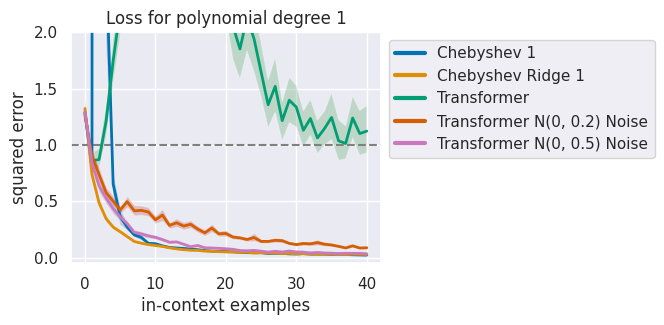

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 2', 'Chebyshev Ridge 2', 'Transformer', 'Transformer N(0, 0.2) Noise', 'Transformer N(0, 0.5) Noise'])


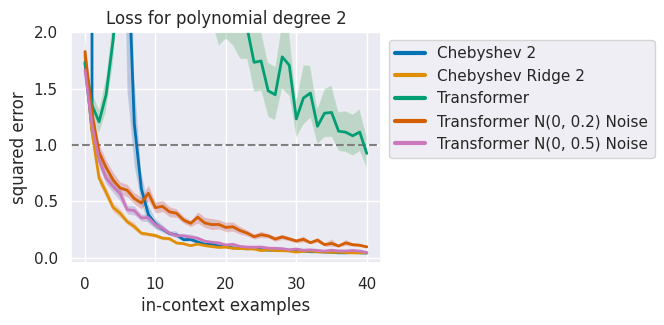

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 3', 'Chebyshev Ridge 3', 'Transformer', 'Transformer N(0, 0.2) Noise', 'Transformer N(0, 0.5) Noise'])


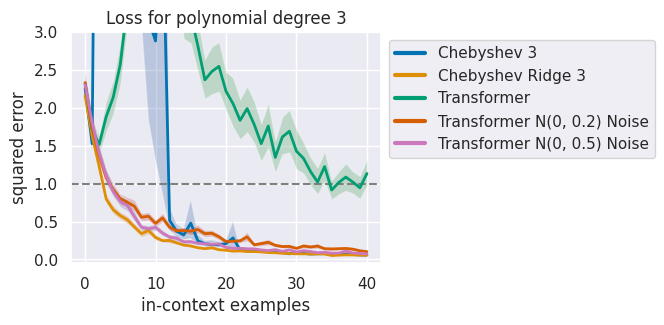

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 4', 'Chebyshev Ridge 4', 'Transformer', 'Transformer N(0, 0.2) Noise', 'Transformer N(0, 0.5) Noise'])


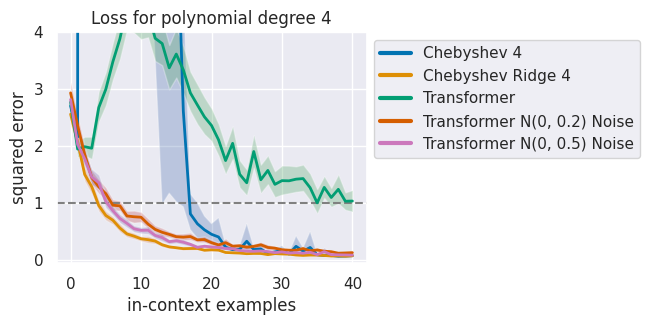

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 5', 'Chebyshev Ridge 5', 'Transformer', 'Transformer N(0, 0.2) Noise', 'Transformer N(0, 0.5) Noise'])


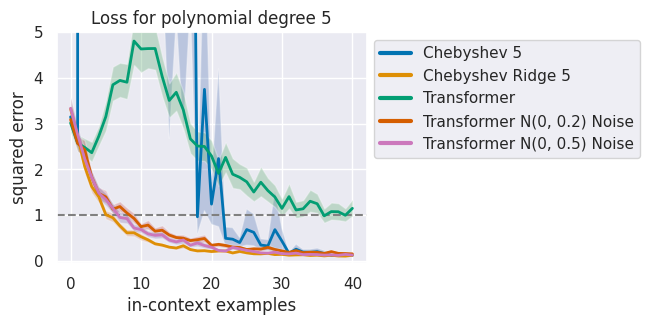

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 6', 'Chebyshev Ridge 6', 'Transformer', 'Transformer N(0, 0.2) Noise', 'Transformer N(0, 0.5) Noise'])


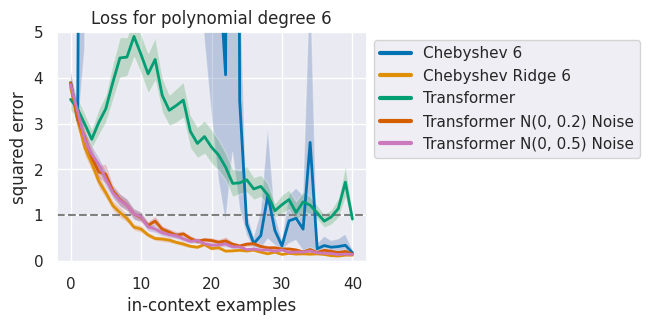

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 7', 'Chebyshev Ridge 7', 'Transformer', 'Transformer N(0, 0.2) Noise', 'Transformer N(0, 0.5) Noise'])


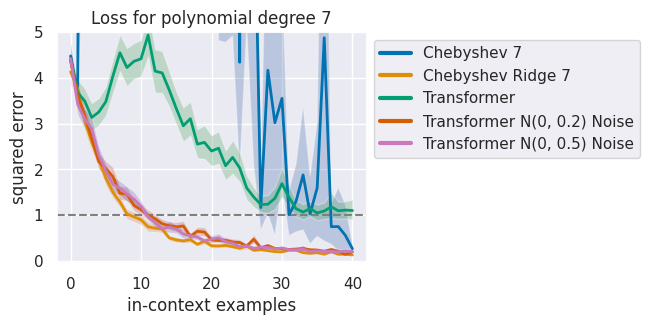

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 8', 'Chebyshev Ridge 8', 'Transformer', 'Transformer N(0, 0.2) Noise', 'Transformer N(0, 0.5) Noise'])


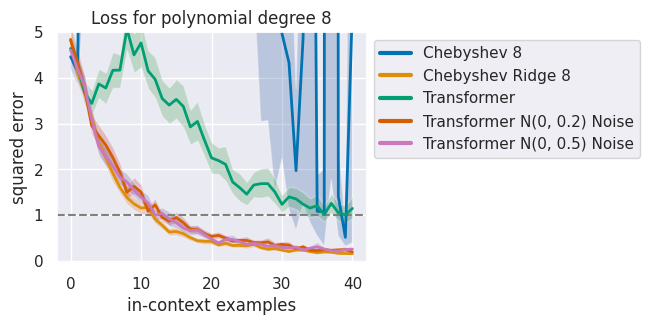

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 9', 'Chebyshev Ridge 9', 'Transformer', 'Transformer N(0, 0.2) Noise', 'Transformer N(0, 0.5) Noise'])


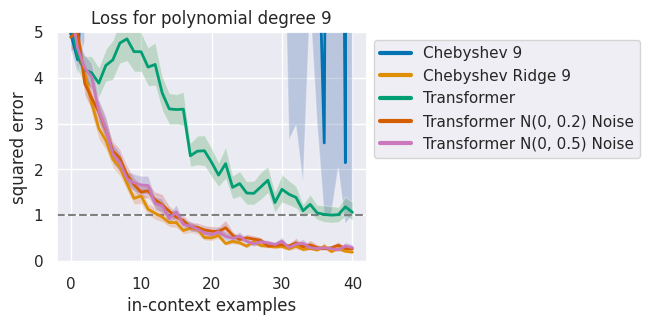

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 10', 'Chebyshev Ridge 10', 'Transformer', 'Transformer N(0, 0.2) Noise', 'Transformer N(0, 0.5) Noise'])


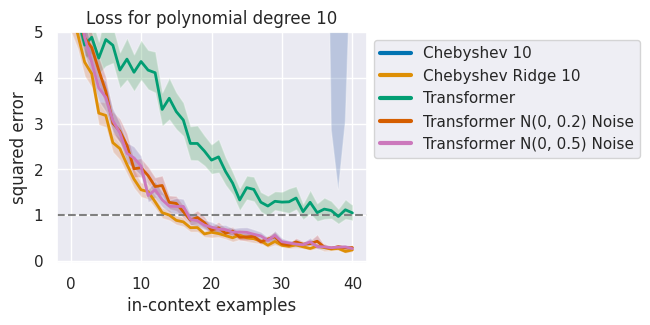

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 11', 'Chebyshev Ridge 11', 'Transformer', 'Transformer N(0, 0.2) Noise', 'Transformer N(0, 0.5) Noise'])


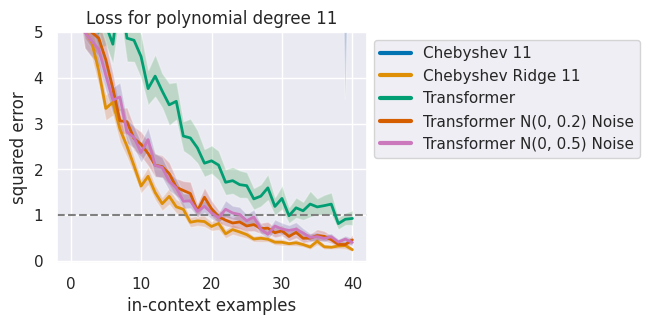

In [7]:
def valid_row(r, run_id):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=lambda x: valid_row(x, run_id), smoothing=0.00)
print(metrics["degree-" + str(1)])
#metrics_smooth = collect_results(run_dir, df, valid_row=lambda x: valid_row(x, run_id), smoothing=0.01)
#metrics_big = collect_results(run_dir, df, valid_row= lambda x: valid_row(x, run_id_big), smoothing=0.00)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

#for k, v in metrics_big.items():
#    for k2, v2 in v.items():
#        if "Transformer" in k2:
#            metrics[k][k2] = v2
#for k, v in metrics_smooth.items():
#    for k2, v2 in v.items():
#        if "Transformer" in k2:
#            metrics[k][k2+ " Smoothed"] = v2

ylims = [2, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5]
for degree in range(1, 12):
    models = get_model_names_for_degree(degree)
    print(models)
    print(metrics.keys())
    print(metrics["degree-" + str(degree)].keys())
    basic_plot(metrics["degree-" + str(degree)], models=models, ylim=ylims[degree-1])
    plt.title("Loss for polynomial degree " + str(degree))
    plt.savefig("graphs/degree-" + str(degree) + ".png", dpi=300, bbox_inches='tight')
    plt.show()